<a href="https://colab.research.google.com/github/MarlenGabrich/GTF/blob/main/Copia_de_Intro_Paquetes_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#    CARACTERIZACIÓN ⚒



1.   Funciones de distribución
2.   Correlación de propiedades
3.   Lumping


In [333]:
# Módulos:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [334]:
# Lectura de archivo
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/main/com-fede" > com.csv
df = pd.read_csv('com.csv')

#Acomodo el índice e imprimo
df = df.reset_index(drop=False).rename(columns={'index': 'ID'})
df = df.set_index("component")
df

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   667  100   667    0     0   5422      0 --:--:-- --:--:-- --:--:--  5422


,ID,molar_percentage,molar_mass,density
component,,,,
N2,0,0.49,—,—
CO2,1,0.31,—,—
C1,2,44.01,—,—
C2,3,3.84,—,—
C3,4,1.12,—,—
iC4,5,0.61,—,—
nC4,6,0.72,—,—
iC5,7,0.69,—,—
nC5,8,0.35,—,—


### SCN
Hago una primera agrupación de limpieza para trabajar con SCN. 


---


Forzar balance

In [326]:
# Saco la división i-C y n-C
letdel = "ni(\d+)"
for i in range (len(letdel)-5):
  df.index = df.index.str.replace(letdel[i],r"",regex=True)

#Agrupo y ordeno
df_ID = df.groupby([df.index])['ID'].agg('mean')
df_mbc = df.groupby(['component','molar_mass','density'])['molar_percentage'].agg('sum').reset_index().set_index('component').assign(ID=df_ID)
df_mbc = df_mbc.sort_values(by='ID', ascending=True)
df_mbc

,molar_mass,density,molar_percentage,ID
component,,,,
N2,—,—,0.49,0.0
CO2,—,—,0.31,1.0
C1,—,—,44.01,2.0
C2,—,—,3.84,3.0
C3,—,—,1.12,4.0
C4,—,—,1.33,5.5
C5,—,—,1.04,7.5
C6,—,—,1.04,9.0
C7,96,0.738,2.87,10.0


Text(17, 8, '100.02')

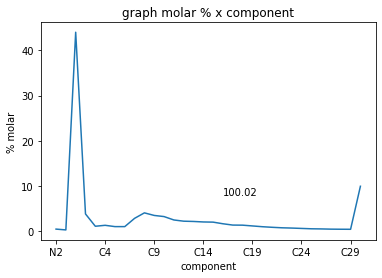

In [330]:
df_mbc['molar_percentage'][:].plot()
plt.ylabel('% molar')
plt.title('graph molar % x component')
suma = df_mbc['molar_percentage'].sum()
plt.text(17,8,round(suma,2))

# 1. Función de distribución

In [468]:
# defino:

z_plus_max = df_mbc["molar_percentage"].values[-1]
m_plus_max = float(df_mbc["molar_mass"].values[-1])
c_max = 80 #Pedersen
c_plus_n = int(df_mbc.index.values[-1].replace('C',"").replace('+',""))

#Voy a arrancar a distribuir desde C7, entonces:
z_exp = df_mbc['molar_percentage']['C7':df_mbc.index[-2]].astype(float)

c_n=df_mbc.index
cdel = "C+"
for i in range (len(cdel)):
  c_n = c_n.str.replace(cdel[i],r"",regex=True)
c_n=c_n.values[8:-1].astype('int64')

30

## Ajuste de parámetros

In [425]:
from scipy.optimize import curve_fit # Ajustar curva
from scipy.optimize import root_scalar # Hallar ceros
from scipy.optimize import minimize, minimize_scalar # Minimizar funciones

Ecuaciones utilizadas:
- Función de distribución: $A + B \ln{z_i}$
- Función de fracción molar: $e^{\frac{CN - A}{B}}$
- Masa molar según Pedersen: $14CN - 4$
- Masa molar según Cismondi: $84 + C(CN-6)$

In [450]:
def carbon_number(z, A, B):
    return A + B * np.log(z)

def molar_fraction(cn, A, B):
    return np.exp((cn - A)/B)

def pedersen_M(cn):
    return 14 * cn - 4

def cismondi_M(cn, C):
    return 84 + C*(cn - 6)

In [456]:
A, B = curve_fit(carbon_number, z_exp, c_n)[0]

exp_molar_mass = df_mbc["molar_mass"]['C7':df_mbc.index[-2]].astype(float)
C = curve_fit(cismondi_M, c_n, exp_molar_mass)[0]

Text(2.5, 20, 'Cn = A + B In Zn')

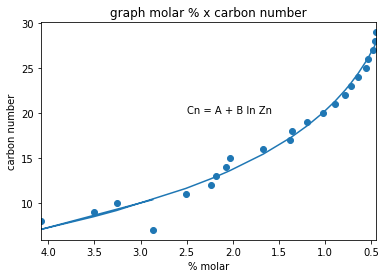

In [467]:
plt.plot(z_exp, carbon_number(z_exp, A, B))
plt.scatter(z_exp, c_n)
plt.ylabel('carbon number')
plt.xlabel('% molar')
plt.xlim(max(z_exp),min(z_exp))
plt.title('graph molar % x carbon number')
plt.text(2.5,20,'Cn = A + B In Zn')

## Mimimización de funciones


In [493]:
#Ingreso nc inicial, final y la func de cálculo de masa molar que va a utilizar
def res_fraction(c_max, c_min, m_func):   
    n = 1000                                                                      #número de veces que voy a iterar
    c_range = np.linspace(c_min, c_max, n, dtype=int)
    z_values = molar_fraction(c_range, A, B)                                      #calcula la fracción molar con la ec. de Pedersen
    m_values = m_func(c_range)                                                    #saca los valores de masa molar de todo el rango de nc con la ec. que definí al principio
    
    m_plus = np.array([])                                                         
    
    for i in range(0, n):
        m_plus = np.append(                                                       #completa Masa molar de la fracción + (ecuación de Pedersen) para dif. Cmax
            m_plus,
            (z_values[:i]*m_values[:i]).sum() / z_values[:i].sum()
        )    

    return z_values, c_range, m_values, m_plus

In [495]:
z, c, m, mp = res_fraction(80, c_plus_n, pedersen_M)

dfmin = pd.DataFrame()
dfmin['molarperc_values']=z
dfmin['component_range']=c
dfmin['molarmass_values']=m
dfmin['molarmass_plus']=mp

dfmin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


,molarperc_values,component_range,molarmass_values,molarmass_plus
0,0.353625,30,416,NaN
1,0.353625,30,416,416.000000
2,0.353625,30,416,416.000000
3,0.353625,30,416,416.000000
4,0.353625,30,416,416.000000
...,...,...,...,...
995,0.001906,79,1102,536.974111
996,0.001906,79,1102,536.989583
997,0.001906,79,1102,537.005055
998,0.001906,79,1102,537.020525


In [479]:
def fit_mp(cmax, obj_mp, c_plus_n, m_func):
    """Error cuadrado entre peso molecular M+ estimado y real.
    """
    _, _, _, mp = res_fraction(cmax, c_plus_n, m_func)
    return (mp[-1] - obj_mp)**2

In [ ]:
cis = lambda x: cismondi_M(x, C)

minimize_scalar(
        fit_mp,
        args=(m_plus_max, c_plus_n, cis),
)

     fun: 0.00028737650868136655
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 30
     nit: 23
 success: True
       x: 36.992338412022136

In [ ]:
minimize_scalar(
        fit_mp,
        args=(m_plus_max, c_plus_n, pedersen_M)
    )

     fun: 6.3195203935139135e-06
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 32
     nit: 25
 success: True
       x: 36.42930573126994

## Resolución de ecuaciones diferenciales

Scipy también incluye modulos para la resolución de ecuaciones diferenciales ordinarias.

Resolución de ley cinética: $\frac{dCa(t)}{dt} = -k_d C_a^2 + k_i C_a$

In [ ]:
from scipy.integrate import solve_ivp

def r(t, Ca, kd, ki):
    dCadt = -kd*Ca**2 + ki*Ca
    return dCadt

kd = 3
ki = 0.5
Ca0 = 5

sol = solve_ivp(r,
                t_span=(0, 100),
                y0=(0, Ca0),
                args=(kd, ki)
)

plt.plot(sol["t"], sol["y"][1])
plt.xlim(0, 2)

In [ ]:
for Ca0 in np.linspace(0.1, 1, 5):
    sol = solve_ivp(
                r,
                t_span=(0, 100),
                y0=(0, Ca0),
                args=(kd, ki),
    )
    
    plt.plot(sol['t'], sol['y'][1], label=Ca0)

plt.xlim(0, 5)
plt.legend()